# **<center>Introduction to Video Classification & Human Activity Recognition</center>**

Version adapted to gait classification  : train/test with 2 classes (child - adult)


---



---



**Here are the steps we will perform:**

- **Step 1: Download and Extract the Dataset**
- **Step 2: Visualize the Data with its Labels**
- **Step 3: Read and Preprocess the Dataset**
- **Step 4: Split the Data into Train and Test Set**
- **Step 5: Construct the Model**
- **Step 6: Compile & Train the Model**
- **Step 7: Plot Model’s Loss & Accuracy Curves**
- **Step 8: Make Predictions with the Model**
- **Step 9: Using Single-Frame CNN Method**

Make sure you have pafy, youtube-dl and moviepy packages installed.

In [1]:
!pip install pafy youtube-dl moviepy

#### **Import Required Libraries:**
Start by importing all required libraries.

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

**Set Numpy, Python & Tensorflow seeds to get consistent results.**

In [4]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **Step 1: Download and Extract the Dataset**

Let’s start by downloading the dataset. 

A faire : décrire le dataset

The Dataset we are using is the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php).

**UCF50** is an action recognition dataset which contains:

*   **50** Action Categories consisting of realistic YouTube videos
*   **25** Groups of Videos per Action Category
*   **133** Average Videos per Action Category
*   **199** Average Number of Frames per Video
*   **320** Average Frames Width per Video
*   **240** Average Frames Height per Video
*   **26** Average Frames Per Seconds per Video

After downloading the data, you will need to extract it.


## **Step 2: Visualize the Data with its Labels**
Let's pick some random videos from each class of the dataset and display it, this will give us a good overview of how the dataset look like.

In [5]:
all_classes_names = os.listdir('dataset_age')

In [6]:
all_classes_names

['adult', 'child']

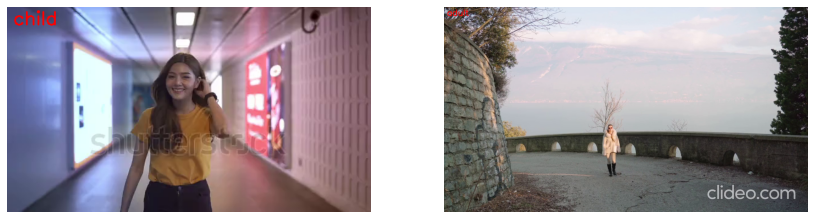

In [7]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('dataset_age')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 2) ### valeur de base : 20

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'dataset_age/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'dataset_age/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## **Step 3: Read & Preprocess the Dataset**

Since we're going to use a classification architecture to train on a video classification dataset, we're goiing to need to preprocess the dataset first.

Now w constants, 
- **`image_height`** and **`image_weight`**: This is the size we will resize all frames of the video to, we're doing this to avoid unneccsary computation.

- **`max_images_per_class`**: Maximum number of training images allowed for each class.

- **`dataset_directory`**: The path of the directory containing the extracted dataset. 

- **`classes_list`**: These are the list of classes we're going to be training on, we're traninng on following 4 classes, you can feel free to change it. 
  - *woman*
  - *man*
  - *girl*
  - *boy*

**Note:** The `image_height`, `image_weight` and `max_images_per_class` constants may be increased for better results, but be warned this will become computationally expensive.

In [8]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "dataset_age"
classes_list = ["adult" , "child"]

model_output_size = len(classes_list)

### **Extract, Resize & Normalize Frames**


Now we'll create a function that will extract frames from each video while performing other preprocessing operation like resizing and normalizing images. 

This method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list and then finally returns that list.

In [9]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

### **Dataset Creation**
Now we'll create another function called  **`create_dataset()`**,  this function uses the **`frame_extraction()`** funciton above and creates our final preprocessed dataset. 

**Here's how this function works:**

1.   Iterate through all the classes mentioned in the `classes_list`
2.   Now for each class iterate through all the video files present in it. 
3.   Call the **frame_extraction** method on each video file.
4.   Add the returned frames to a list called `temp_features`
5.   After all videos of a class are processed, randomly select video frames (equal to **max_images_per_class**) and add them to the list called `features`.
6.   Add labels of the selected videos to the labels list.
7.   After all videos of all classes are processed then return the features and labels as numpy arrays.


So when you call this function, it returns **2** lists:
- a list of feature vectors 
- a list of it's associated labels.


In [10]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

Calling the **create_dataset** method which returns features and labels.

In [11]:
features, labels = create_dataset()

Extracting Data of Class: adult
Extracting Data of Class: child


Now we will convert class labels to one hot encoded vectors.

In [12]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **Step 4: Split the Data into Train and Test Set**
Now we have 2 numpy arrays, one containing all images, the second one contains all class labels in one hot encoded format. Let’s split our data to create a training and a testing set. It’s important that you shuffle your data before the split which we have already done.


In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

## **Step 5: Construct the Model**
Now it’s time to create our CNN model, for this post, we're c reating a simple CNN Classification model with two CNN layers.

In [14]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

### **Check Model’s Structure:**
Using the **plot_model** function you can check the structure of the final model, this is really helpful when you’re creating a complex network and you want to make sure you have constructed the network correctly.

In [15]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## **Step 6: Compile & Train the Model**


Now let's start the training. Before we do that, we also need to complile the model.


In [16]:
#!pip install tensorflow==2.8
#!apt-get install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [17]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
2560/2560 [==============================] - 22s 6ms/step - loss: 0.5339 - accuracy: 0.7781 - val_loss: 0.4059 - val_accuracy: 0.8621
Epoch 2/50
2560/2560 [==============================] - 15s 6ms/step - loss: 0.4831 - accuracy: 0.8045 - val_loss: 0.5096 - val_accuracy: 0.8598
Epoch 3/50
2560/2560 [==============================] - 14s 6ms/step - loss: 0.4588 - accuracy: 0.8180 - val_loss: 0.3811 - val_accuracy: 0.8746
Epoch 4/50
2560/2560 [==============================] - 15s 6ms/step - loss: 0.4474 - accuracy: 0.8201 - val_loss: 0.3904 - val_accuracy: 0.8770
Epoch 5/50
2560/2560 [==============================] - 13s 5ms/step - loss: 0.4326 - accuracy: 0.8261 - val_loss: 0.3992 - val_accuracy: 0.8727
Epoch 6/50
2560/2560 [==============================] - 14s 5ms/step - loss: 0.4138 - accuracy: 0.8368 - val_loss: 0.3354 - val_accuracy: 0.8891
Epoch 7/50
2560/2560 [==============================] - 13s 5ms/step - loss: 0.4128 - accuracy: 0.8351 - val_loss: 0.4554 - val_ac

### **Evaluating Your Trained Model**
Evaluate your trained model on the feature's and label's test sets.

In [18]:
model_evaluation_history = model.evaluate(features_test, labels_test)

100/100 [==============================] - 1s 4ms/step - loss: 0.0750 - accuracy: 0.9837


### **Save Your Model**
You should now save your model for future runs.

In [19]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

## **Step 7: Plot Model’s Loss & Accuracy Curves**
Let's plot our loss and accuracy curves.

In [20]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

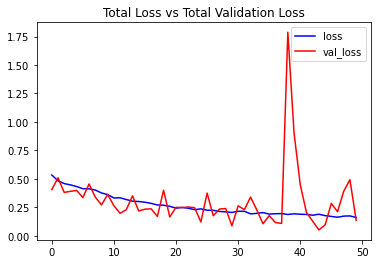

In [21]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

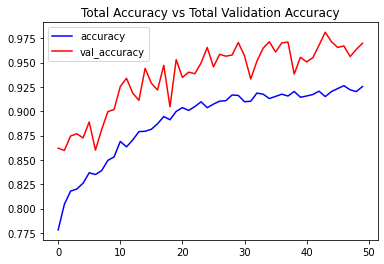

In [22]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## **Step 8: Make Predictions with the Model:**
Now that we have created and trained our model it's time to test it's performance on some test videos.


In [23]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

#### **Download a Test Video:**

In [24]:
pip install pytube

Note: you may need to restart the kernel to use updated packages.


In [25]:
!pip install pafy youtube-dl moviepy

In [27]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1
output_directory = "Youtube_Videos"
video_title = "Test Video"
# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
input_video_file_path = 'Test Video.mp4'


Although the results, are not perfect but you can clearly see that it's much better than the previous approach of predicting on each frame independently.

# On prend la méthode CNN

## **Step 9: Using Single-Frame CNN Method:**
Now let's create a function that will output a singular prediction for the complete video, now this function will take `n` frames from the entire video and make predictions. In the end, it will average the predictions of those <code>n</code> frames to give you the final activity class for that video. You can set the value of <code>n</code> using the <code>predictions_frames_count</code> variable.

This function is useful when you have a video containing one activity and you want to know the activity's name and its score.


In [28]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability*100):.2}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

#### **Test Average Prediction Method On Downloaded Videos:**

In [34]:
video_title = f'{output_directory}/{video_title}.mp4'
input_video_file_path = 'Youtube_Videos/man.mp4'

make_average_predictions(input_video_file_path , 50)

VideoFileClip(input_video_file_path).ipython_display(width = 700)

1/1 [==============================] - 0s 13ms/step
CLASS NAME: adult   AVERAGED PROBABILITY: 9.4e+01
CLASS NAME: child   AVERAGED PROBABILITY: 6.4
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### **Test Average Prediction Method On Recorded Videos:**

In [ ]:
import cv2

def record_video():
    
    cap = cv2.VideoCapture(0)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    writer = cv2.VideoWriter('videotest.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))


    while True:
        ret,frame = cap.read()

        writer.write(frame)

        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break


    cap.release()
    writer.release()
    cv2.destroyAllWindows()



def gait_video():
    
    video = cv2.VideoCapture(0)
    counter = 0 #compteur pour le comptage des mouvements
    stage = None

    if (video.isOpened() == False):
        print("Error reading video file")

    frame_width = int(video.get(3))
    frame_height = int(video.get(4))

    size = (frame_width, frame_height)

    result = cv2.VideoWriter('gait_vid.mp4',cv2.VideoWriter_fourcc(*'MJPG'),10, size)


    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while video.isOpened():
            ret, frame = video.read() ## frame : video sans aucun filtre

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) ## image : video avec mediapipe
            image.flags.writeable = False

            #Make detection
            results = pose.process(image)

            #Recolor image to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            
            
            #Render curl counter setup statux box
            cv2.rectangle(image,(0,0),(100,70),(245,117,16),-1)

            #Rep data
            cv2.putText(image,'REPS' , (30,15),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1, cv2.LINE_AA)

            cv2.putText(image,str(counter),
                        (40,50),
                        cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),1, cv2.LINE_AA)

            #Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

            cv2.imshow('Gait + Prediction', image)

            if ret == True:
                #result.write(frame) ## choisir ici pour l'image sans le squelette Mediapipe
                result.write(image) ## on enregistre l'image avec le squelette Mediapipe
                #cv2.imshow('Gait', frame)

                if counter == 2 or cv2.waitKey(1) & 0xFF == ord('q'): ## on s'arrête si on a fait 2 pas ou arrêt forcé
                    #print("OK")
                    break

            else:
                print("KO")
                
                break


        video.release()
        result.release()
        cv2.destroyAllWindows()
        return counter

In [ ]:
record_video()